In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split
import pickle

from collections import Counter
from models import model__prior_mu_studentT as model, model_prior_mu_normal as model_2

### Data Processing

In [2]:
scaler = StandardScaler()
df = pd.read_pickle('./pickle/df.pkl')

In [3]:
df_sampled = df.sample(1400,random_state=47)

In [4]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [5]:
df_features = scaler.fit_transform(df_features)

In [6]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/7)

df_train_features, df_val_features,df_train_target, df_val_target =  train_test_split(df_train_features,df_train_target,stratify=df_train_target,random_state=47, test_size=1/6)

In [7]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()
df_val_target = df_val_target.to_numpy()

In [8]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=5
tau=10

In [9]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Parameter Tuning

##### Degree of Freedom

In [10]:
degF_range = [4,5,6]

acc_val_degF = []


for degF in degF_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    
    print({degF:acc})
    acc_val_degF.append({degF:acc})
   

[0] ELBO: 24390.9
[1000] ELBO: 16754.1
[2000] ELBO: 11163.3
[3000] ELBO: 7787.5
[4000] ELBO: 5721.7
[5000] ELBO: 4186.3
[6000] ELBO: 3017.6
[7000] ELBO: 2432.1
[8000] ELBO: 2244.9
[9000] ELBO: 2124.5


C:\Users\MNIS\AppData\Local\Temp\ipykernel_27560\1679624983.py:45: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  mean_alpha = mean_alpha.T


{4: 0.475}
[0] ELBO: 29879.3
[1000] ELBO: 22254.1
[2000] ELBO: 15817.4
[3000] ELBO: 10687.3
[4000] ELBO: 7928.0
[5000] ELBO: 5042.2
[6000] ELBO: 3299.4
[7000] ELBO: 2669.2
[8000] ELBO: 2301.8
[9000] ELBO: 2110.0
{5: 0.465}
[0] ELBO: 20687.1
[1000] ELBO: 14523.9
[2000] ELBO: 10185.0
[3000] ELBO: 7178.0
[4000] ELBO: 4810.2
[5000] ELBO: 3509.9
[6000] ELBO: 2694.5
[7000] ELBO: 2391.4
[8000] ELBO: 2093.6
[9000] ELBO: 1867.7
{6: 0.475}


In [16]:
acc_val_degF

[{4: 0.48}, {5: 0.44}, {6: 0.455}]

##### Tau in Variance

In [17]:
tau_range = [1,10,50,100]
degF = 4

acc_val_tau = []


for tau in tau_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({tau:acc})
    acc_val_tau.append({tau:acc})
   

[0] ELBO: 5754.5
[1000] ELBO: 2438.3
[2000] ELBO: 1879.5
[3000] ELBO: 1728.4
[4000] ELBO: 1688.5
[5000] ELBO: 1657.9
[6000] ELBO: 1666.3
[7000] ELBO: 1643.2
[8000] ELBO: 1639.3
[9000] ELBO: 1641.2
{1: 0.475}
[0] ELBO: 17154.3
[1000] ELBO: 10999.9
[2000] ELBO: 7443.2
[3000] ELBO: 4593.6
[4000] ELBO: 3527.1
[5000] ELBO: 2442.9
[6000] ELBO: 2074.9
[7000] ELBO: 1827.1
[8000] ELBO: 1758.8
[9000] ELBO: 1736.8
{10: 0.475}
[0] ELBO: 103148.5
[1000] ELBO: 95104.4
[2000] ELBO: 87091.9
[3000] ELBO: 81323.9
[4000] ELBO: 73349.9
[5000] ELBO: 68253.2
[6000] ELBO: 61373.4
[7000] ELBO: 56105.8
[8000] ELBO: 51189.1
[9000] ELBO: 47619.2
{50: 0.19}
[0] ELBO: 171311.0
[1000] ELBO: 163557.5
[2000] ELBO: 156508.2
[3000] ELBO: 150885.5
[4000] ELBO: 144258.3
[5000] ELBO: 136846.2
[6000] ELBO: 131783.7
[7000] ELBO: 125509.1
[8000] ELBO: 119432.5
[9000] ELBO: 115436.5
{100: 0.215}


In [18]:
acc_val_tau

[{1: 0.475}, {10: 0.475}, {50: 0.19}, {100: 0.215}]

### Model implementation using normal distribution for mu prior 

##### lambda

In [11]:
lambda_range = [1,5,10]

acc_val_lambda = []


for lambda_ in lambda_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model_2)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model_2, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, lambda_, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model_2, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, lambda_, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({lambda_:acc})
    acc_val_lambda.append({lambda_:acc})
   

[0] ELBO: 20002.0
[1000] ELBO: 13298.3
[2000] ELBO: 8430.2
[3000] ELBO: 5532.6
[4000] ELBO: 3891.9
[5000] ELBO: 2787.0
[6000] ELBO: 2164.2
[7000] ELBO: 1863.8
[8000] ELBO: 1786.4
[9000] ELBO: 1781.1
{1: 0.475}
[0] ELBO: 27001.0
[1000] ELBO: 19311.6
[2000] ELBO: 14241.7
[3000] ELBO: 9709.3
[4000] ELBO: 6255.6
[5000] ELBO: 4098.4
[6000] ELBO: 2928.1
[7000] ELBO: 2288.0
[8000] ELBO: 2051.9
[9000] ELBO: 1952.6
{5: 0.43}
[0] ELBO: 28910.9
[1000] ELBO: 22360.0
[2000] ELBO: 17272.4
[3000] ELBO: 12564.9
[4000] ELBO: 9100.2
[5000] ELBO: 6545.2
[6000] ELBO: 4318.1
[7000] ELBO: 3088.4
[8000] ELBO: 2540.3
[9000] ELBO: 2204.0
{10: 0.445}


In [13]:
guide = AutoMultivariateNormal(model_2)
lambda_ = 1 
# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model_2, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, lambda_, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))
        
        


predictive = Predictive(model_2, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, lambda_, tau, y_train)


samples_alpha = samples["alpha"].detach().squeeze()
samples_beta = samples["beta"].detach().squeeze()


mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T
mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T


y_val_pred = np.zeros((N_val,n_cat))

for n in range(N_val):

    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

    p =  softmax(probs)
    y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    
y_val_pred = y_val_pred[:,0]

acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
print({lambda_:acc})
acc_val_lambda.append({lambda_:acc})

[0] ELBO: 24415.5
[1000] ELBO: 17082.1
[2000] ELBO: 11229.9
[3000] ELBO: 7928.0
[4000] ELBO: 5722.9
[5000] ELBO: 3967.4
[6000] ELBO: 3010.7
[7000] ELBO: 2474.7
[8000] ELBO: 2016.5
[9000] ELBO: 1923.5
{1: 0.45}


In [14]:
predictive = Predictive(model_2, guide=guide, num_samples=10000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

In [20]:
samples_alpha = samples["alpha"].detach().squeeze()
samples_beta = samples["beta"].detach().squeeze()

mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

In [21]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli

y_train_pred = y_train_pred[:,0]
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.491


In [22]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [23]:
y_test_pred = y_test_pred[:,0]

In [24]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.45


#### Final Model training 

In [20]:
degF=4
tau=1

In [21]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4366.0
[1000] ELBO: 1857.9
[2000] ELBO: 1723.5
[3000] ELBO: 1668.0
[4000] ELBO: 1668.5
[5000] ELBO: 1645.9
[6000] ELBO: 1641.8
[7000] ELBO: 1642.1
[8000] ELBO: 1638.2
[9000] ELBO: 1631.3


In [22]:
predictive = Predictive(model, guide=guide, num_samples=10000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

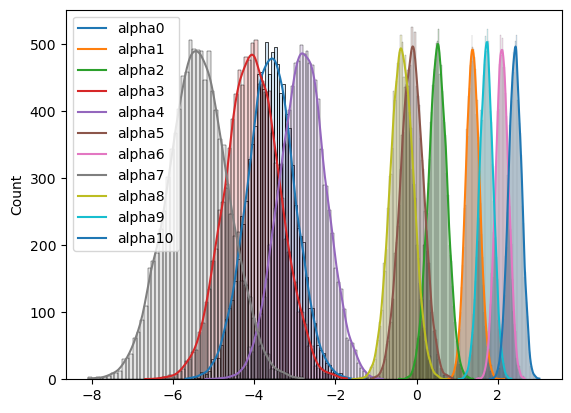

In [23]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

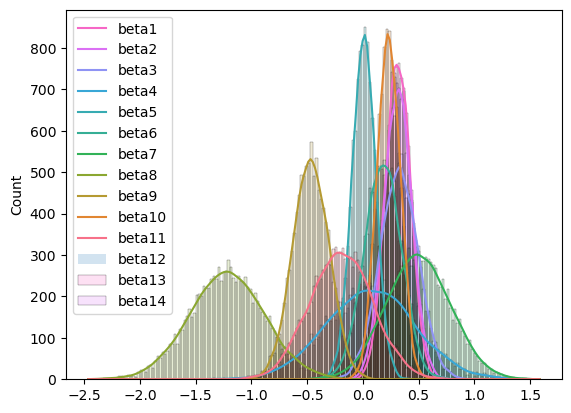

In [24]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [25]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [27]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [28]:
y_train_pred = y_train_pred[:,0]

In [29]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.503


### Inference and computation of accuracy on the test dataset 

In [30]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [31]:
y_test_pred = y_test_pred[:,0]

In [33]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.46
